In [28]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv('/content/netflix_titles.csv')

# Connect to SQLite and save the table
conn = sqlite3.connect('netflix.db')
df.to_sql('netflix', conn, if_exists='replace', index=False)

# Helper function to run queries and return dataframes
def run_query(query):
    return pd.read_sql_query(query, conn)

,type,total_count,percentage
0,Movie,6131,69.62
1,TV Show,2676,30.38


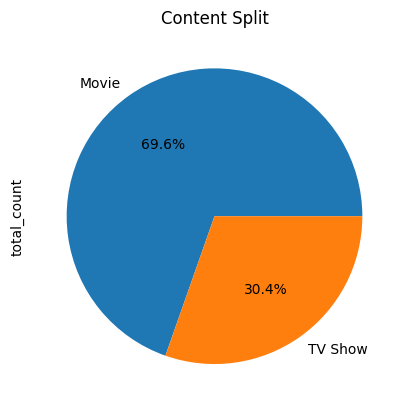

In [29]:
query_1 = """
SELECT
    type,
    COUNT(*) AS total_count,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM netflix), 2) AS percentage
FROM netflix
GROUP BY type;
"""

df_distribution = run_query(query_1)
display(df_distribution)

# Quick Plot
df_distribution.set_index('type')['total_count'].plot(kind='pie', autopct='%1.1f%%', title='Content Split')
plt.show()

In [30]:
query_2 = """
SELECT
    country,
    COUNT(*) AS total_content
FROM netflix
WHERE country IS NOT NULL
GROUP BY country
ORDER BY total_content DESC
LIMIT 10;
"""

df_countries = run_query(query_2)
display(df_countries)

,country,total_content
0,United States,2818
1,India,972
2,United Kingdom,419
3,Japan,245
4,South Korea,199
5,Canada,181
6,Spain,145
7,France,124
8,Mexico,110
9,Egypt,106


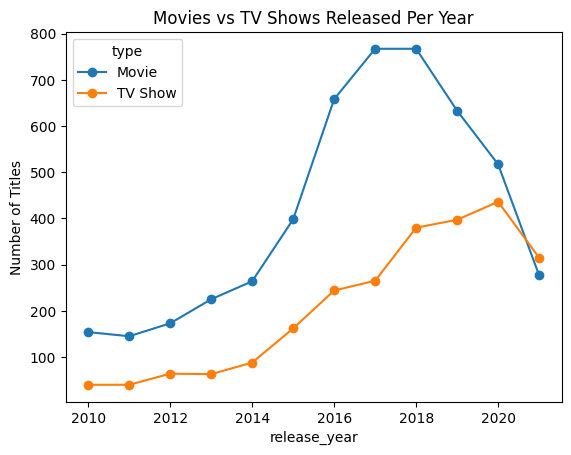

In [31]:
query_3 = """
SELECT
    release_year,
    type,
    COUNT(*) AS additions
FROM netflix
WHERE release_year >= 2010 AND release_year <= 2021
GROUP BY release_year, type
ORDER BY release_year ASC;
"""

df_trends = run_query(query_3)

# Pivot the data for better plotting
df_pivot = df_trends.pivot(index='release_year', columns='type', values='additions')
df_pivot.plot(kind='line', marker='o', title='Movies vs TV Shows Released Per Year')
plt.ylabel('Number of Titles')
plt.show()

In [33]:
query_4 = """
SELECT
    title,
    type,
    duration,
    CASE
        WHEN duration LIKE '%min' THEN CAST(REPLACE(duration, ' min', '') AS INT)
        ELSE NULL
    END AS duration_minutes,
    CASE
        WHEN duration LIKE '%Season%' THEN CAST(REPLACE(REPLACE(duration, ' Seasons', ''), ' Season', '') AS INT)
        ELSE NULL
    END AS seasons_count
FROM netflix
WHERE type = 'Movie'
ORDER BY duration_minutes DESC
LIMIT 10;
"""

df_duration = run_query(query_4)
display(df_duration)

,title,type,duration,duration_minutes,seasons_count
0,Black Mirror: Bandersnatch,Movie,312 min,312,None
1,Headspace: Unwind Your Mind,Movie,273 min,273,None
2,The School of Mischief,Movie,253 min,253,None
3,No Longer kids,Movie,237 min,237,None
4,Lock Your Girls In,Movie,233 min,233,None
5,Raya and Sakina,Movie,230 min,230,None
6,Once Upon a Time in America,Movie,229 min,229,None
7,Sangam,Movie,228 min,228,None
8,Lagaan,Movie,224 min,224,None
9,Jodhaa Akbar,Movie,214 min,214,None


In [34]:
query_5 = """
SELECT
    director,
    COUNT(*) AS total_titles
FROM netflix
WHERE director IS NOT NULL
  AND (listed_in LIKE '%International%' OR listed_in LIKE '%Dramas%')
GROUP BY director
ORDER BY total_titles DESC
LIMIT 10;
"""

df_directors = run_query(query_5)
display(df_directors)

,director,total_titles
0,Cathy Garcia-Molina,13
1,Youssef Chahine,12
2,Martin Scorsese,9
3,David Dhawan,9
4,Yılmaz Erdoğan,8
5,Kunle Afolayan,8
6,Johnnie To,8
7,Hakan Algül,8
8,Toshiya Shinohara,7
9,S.S. Rajamouli,7


In [37]:
# 1. Load the data
df = pd.read_csv('netflix_titles.csv')

# 2. Function to explode comma-separated strings into separate rows
def explode_column(dataframe, column_name):
    # Split the strings into lists and explode them
    exploded = dataframe.assign(**{column_name: dataframe[column_name].str.split(', ')})
    exploded = exploded.explode(column_name)
    # Clean up whitespace
    exploded[column_name] = exploded[column_name].str.strip()
    return exploded

# 3. Create specific dataframes for analysis
df_actors = explode_column(df[['show_id', 'cast']], 'cast').dropna()
df_countries = explode_column(df[['show_id', 'country']], 'country').dropna()

# 4. Save these as new tables in your SQL database
df_actors.to_sql('netflix_cast', conn, if_exists='replace', index=False)
df_countries.to_sql('netflix_countries', conn, if_exists='replace', index=False)

print("Exploded tables 'netflix_cast' and 'netflix_countries' are ready!")

Exploded tables 'netflix_cast' and 'netflix_countries' are ready!


In [39]:
query_actors = """
SELECT
    "cast" AS actor_name,
    COUNT(*) AS total_appearances
FROM netflix_cast
GROUP BY actor_name
ORDER BY total_appearances DESC
LIMIT 10;
"""

df_top_actors = run_query(query_actors)
display(df_top_actors)

,actor_name,total_appearances
0,Anupam Kher,43
1,Shah Rukh Khan,35
2,Julie Tejwani,33
3,Takahiro Sakurai,32
4,Naseeruddin Shah,32
5,Rupa Bhimani,31
6,Om Puri,30
7,Akshay Kumar,30
8,Yuki Kaji,29
9,Paresh Rawal,28


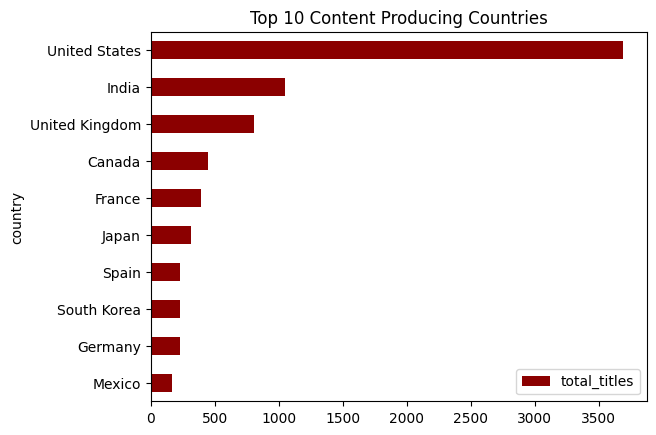

In [40]:
query_global = """
SELECT
    country,
    COUNT(*) AS total_titles
FROM netflix_countries
GROUP BY country
ORDER BY total_titles DESC
LIMIT 10;
"""

df_global_clean = run_query(query_global)

df_global_clean.plot(kind='barh', x='country', y='total_titles',
                     color='darkred', title='Top 10 Content Producing Countries')
plt.gca().invert_yaxis() # Highest at the top
plt.show()

In [41]:
query_duos = """
SELECT
    n.director,
    c.cast AS actor_name,
    COUNT(*) AS collaborations
FROM netflix n
JOIN netflix_cast c ON n.show_id = c.show_id
WHERE n.director IS NOT NULL
GROUP BY n.director, actor_name
ORDER BY collaborations DESC
LIMIT 10;
"""

df_duos = run_query(query_duos)
display(df_duos)

,director,actor_name,collaborations
0,Rajiv Chilaka,Jigna Bhardwaj,17
1,Rajiv Chilaka,Julie Tejwani,17
2,Rajiv Chilaka,Rajesh Kava,17
3,Rajiv Chilaka,Rupa Bhimani,16
4,Rajiv Chilaka,Vatsal Dubey,15
5,Rajiv Chilaka,Mousam,12
6,Rajiv Chilaka,Swapnil,12
7,Suhas Kadav,Saurav Chakraborty,8
8,S.S. Rajamouli,Anushka Shetty,7
9,S.S. Rajamouli,Nassar,7


In [42]:
from sklearn.linear_model import LinearRegression
import numpy as np

# 1. Prepare Data using SQL
query_growth = """
SELECT release_year, COUNT(*) as total_titles
FROM netflix
WHERE release_year BETWEEN 2010 AND 2021
GROUP BY release_year
ORDER BY release_year
"""
df_growth = run_query(query_growth)

# 2. Reshape for Modeling
X = df_growth['release_year'].values.reshape(-1, 1) # Features (Year)
y = df_growth['total_titles'].values # Target (Count)

# 3. Train the Model
model = LinearRegression()
model.fit(X, y)

# 4. Predict for 2026
future_years = np.array([[2022], [2023], [2024], [2025], [2026]])
predictions = model.predict(future_years)

print(f"Predicted titles for 2026: {int(predictions[-1])}")

Predicted titles for 2026: 1486


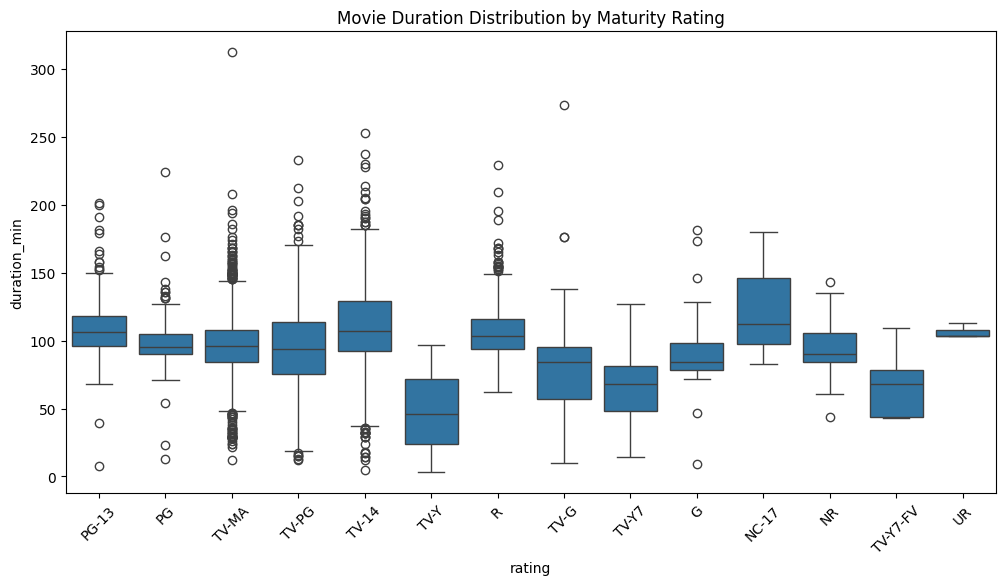

P-Value: 0.0000
Result: Statistically Significant. Content rating does influence movie length.


In [43]:
import seaborn as sns
from scipy import stats

# 1. Get Movie Data with cleaned durations
query_stat = """
SELECT rating,
       CAST(REPLACE(duration, ' min', '') AS INT) as duration_min
FROM netflix
WHERE type = 'Movie' AND duration LIKE '% min' AND rating IS NOT NULL
"""
df_stat = run_query(query_stat)

# 2. Visualization (The Statistical Spread)
plt.figure(figsize=(12, 6))
sns.boxplot(x='rating', y='duration_min', data=df_stat)
plt.title('Movie Duration Distribution by Maturity Rating')
plt.xticks(rotation=45)
plt.show()

# 3. ANOVA Test
# We group durations by rating
groups = [df_stat[df_stat['rating'] == r]['duration_min'] for r in df_stat['rating'].unique()]
f_stat, p_val = stats.f_oneway(*groups)

print(f"P-Value: {p_val:.4f}")
if p_val < 0.05:
    print("Result: Statistically Significant. Content rating does influence movie length.")
else:
    print("Result: Not Significant. Rating and duration are likely independent.")

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# 1. Vectorize the 'description' column
tfidf = TfidfVectorizer(stop_words='english')
matrix = tfidf.fit_transform(df['description'].fillna(''))

# 2. Apply K-Means to find 5 hidden "Themes"
km = KMeans(n_clusters=5, random_state=42)
df['theme_cluster'] = km.fit_predict(matrix)

# 3. See what the clusters look like
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names_out()
for i in range(5):
    print(f"Cluster {i}: {[terms[ind] for ind in order_centroids[i, :5]]}")

Top terms per cluster:
Cluster 0: ['murder', 'police', 'ex', 'detective', 'cop']
Cluster 1: ['friends', 'best', 'new', 'love', 'help']
Cluster 2: ['life', 'family', 'new', 'love', 'documentary']
Cluster 3: ['young', 'world', 'woman', 'man', 'life']
Cluster 4: ['daughter', 'comedy', 'special', 'mother', 'stand']
